In [1]:
!pip install tqdm
!pip install torchmetrics

In [2]:
## Import essentials
import numpy as np
import torch
import os
import glob
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn



In [3]:
### Create Dataloader

import json
from torch.utils.data import Dataset
from PIL import Image

class BDD_Dataset(Dataset):
    def __init__(self, transforms, split='train'):
        super(BDD_Dataset, self).__init__()
        self.transforms = transforms
        self.split = split

        self.label_dirs = glob.glob(os.path.join("dataset/bdd100k/labels/seg_track_20/rles", split, "*.json"))
        self.data_paths = self.load_data()

        self.label_dict = {
           "pedestrian" :    1,
            "rider":         2,
            "car":           3,
            "truck":         4,
            "bus":           5, 
            "train":         6,
            "motorcycle":    7,
            "bicycle":       8,
            "traffic light": 9,
            "traffic sign":  10
        }
        
    
    def load_data(self):
        data_paths = []
        for lfile in self.label_dirs:
            file = open(lfile)
            json_file_data = json.load(file)
            for frame in json_file_data['frames']:
                name = os.path.join(frame['videoName'], frame['name'])
                all_objects = []
                for object in frame['labels']:
                    label = object['category']
                    x1 = object['box2d']['x1']
                    y1 = object['box2d']['y1']
                    x2 = object['box2d']['x2']
                    y2 = object['box2d']['y2']
                    bbox = [x1, y1, x2, y2]
                    if x1 < 0 or y1 < 0 or x2 < 0 or y2 < 0 or x2 - x1 <= 0 or y2 - y1 <= 0:
                        continue 
                    all_objects.append((label, list(bbox)))
                if len(all_objects) == 0:
                    continue
                data_paths.append((name, all_objects))
                
            file.close()
        return data_paths


    def __len__(self):
        return len(self.data_paths)

    def load_image(self, name):
        img_path = os.path.join(os.path.join("dataset/bdd100k/images/seg_track_20", self.split, name))
        img = Image.open(img_path).convert("RGB")
        return img
        

    def __getitem__(self, idx):
        name, infos = self.data_paths[idx]
        img = self.load_image(name)
        label = []
        bbox = []
        for info in infos:
            label.append(self.label_dict[info[0]])
            bbox.append(info[1])
        label = torch.tensor(label) 
        bbox = torch.tensor(bbox).float()
        targets = {
            "labels" : label,
            "boxes": bbox
        }
        return self.transforms(img), targets



#### Testing 
# d = BDD_Dataset(transforms=transforms.ToTensor(), split='val')
# print(len(d))

####


In [4]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate(model, data_loader, device, train=False):
    torch.cuda.empty_cache()
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for idx, (images, targets) in enumerate(data_loader):
            if train and idx > 1000:
                continue
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model.val(images)
            metric.update(outputs, targets)
        result = metric.compute()
        mAP = result['map']
        mAR = result['mar_1']
        f1_score = 2 * (mAP * mAR) / (mAP + mAR)
    
    return mAP, mAR, f1_score
            

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

class Trainer():
    def __init__(self, model, num_epochs, optimizer, train_loader, val_loader, device, save_path, lr_scheduler=None, load_path=None):
        self.model = model
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.lr_scheduler = lr_scheduler
        
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)
            
        self.train_loss_history = defaultdict(list)
        self.val_acc_history = defaultdict(list)
        self.train_acc_history = defaultdict(list)
        
        if load_path is not None:
            checkpoint = torch.load(os.path.join(load_path, 'checkpoint.pt'))
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.train_loss_history = checkpoint['train_loss_history']
            self.train_acc_history = checkpoint['train_acc_history']
            self.val_acc_history = checkpoint['val_acc_history']
    

    def train(self):
        val_acc = -1
        for epoch in range(self.num_epochs):
            torch.cuda.empty_cache()
            self.model.train()
            loss_values = defaultdict(list)
            for images, targets in tqdm(self.train_loader, desc="Iterations: "):
                self.optimizer.zero_grad()
                images = list(image.to(self.device) for image in images)
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                loss_dict = self.model(images, targets)
                final_loss = sum(loss for loss in loss_dict.values())
                final_loss.backward()
                self.optimizer.step()
                for key, value in loss_dict.items():
                    loss_values[key].append(value.item())
            
            if self.lr_scheduler != None:
                self.lr_scheduler.step()
                
            loss_out = ""
            for key, value in loss_values.items():
                mean_ = np.mean(np.array(value))
                self.train_loss_history[key].append(mean_)
                loss_out += key + " = " + str(mean_) + ", "
            tqdm.write("Epoch - "+str(epoch+1)+" : "+loss_out)
            
            if epoch % 3 == 0:
                mAP_train, mAR_train, f1_train = evaluate(self.model, self.train_loader, self.device, train=True)
                mAP_val, mAR_val, f1_val = evaluate(self.model, self.val_loader, self.device)
                tqdm.write("Train Accuracy: mAP="+str(mAP_train.item()))
                tqdm.write("Val Accuracy: mAP="+str(mAP_val.item()))
                self.train_acc_history['mAP'].append(mAP_train.item())
                self.val_acc_history['mAP'].append(mAP_val.item())
                if val_acc < mAP_val:
                    self.save_model()
                    val_acc = mAP_val
    
    def save_model(self):
        torch.save({
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'train_loss_history': self.train_loss_history,
        'train_acc_history': self.train_acc_history,
        'val_acc_history': self.val_acc_history
    }, os.path.join(self.save_path, 'checkpoint.pt'))
        
    def plot_history(self):
        for key in self.train_loss_history.keys():
            plt.figure(figsize=(4,4))
            iters_ = np.arange(0, len(self.train_loss_history[key]))
            plt.plot(iters_, np.array(self.train_loss_history[key]), label=key)
            plt.legend(loc="upper left")
            plt.show()
        
        for key, value in self.train_acc_history.items():
            plt.figure(figsize=(4,4))
            iters_ = np.arange(0, len(self.train_acc_history[key]))
            plt.plot(iters_, np.array(self.train_acc_history[key]), label="Train "+ key)
            plt.plot(iters_, np.array(self.val_acc_history[key]), label="Val " + key)
            plt.legend(loc="upper left")
            plt.show()
        

    def vis_results(self, threshold):
        torch.cuda.empty_cache()
        self.model.eval()
        label_dict = self.val_loader.dataset.label_dict
        p = dict(zip(label_dict.values(),label_dict.keys()))
        colors = np.random.uniform(0, 255, size=(len(p), 3))
        with torch.no_grad():
            rng = np.random.default_rng()
            idxs = list(rng.choice(len(self.train_loader), size=5, replace=False))
            for idx, (images, targets) in enumerate(self.val_loader):
                if idx in idxs:
                    images = list(image.to(self.device) for image in images)
                    outputs = self.model.val(images)[0]
                    img = images[0].permute(1,2,0).cpu().detach().numpy()
                    img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
                    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
                    for i in range(len(outputs['boxes'])):
                        if outputs['scores'][i].item() > threshold:
                            label_idx = outputs['labels'][i].item()
                            label = "{}: {:.2f}%".format(p[label_idx], outputs['scores'][i].item() * 100)
                            box = outputs["boxes"][i].detach().cpu().numpy()
                            (startX, startY, endX, endY) = box.astype("int")
                            img = cv2.rectangle(img, (startX, startY), (endX, endY), colors[label_idx], 2)
                            y = startY - 5 if startY - 5 > 5 else startY + 5
                            img = cv2.putText(img, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[label_idx], 2)
                    ax.set_axis_off()
                    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        
                
                
                
            

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = BDD_Dataset(transforms=transforms.Compose(
                                        [transforms.ToTensor()])
                                        , split='train')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, \
    collate_fn=collate_fn, pin_memory=True)

val_dataset = BDD_Dataset(transforms=transforms.Compose(
                                    [transforms.ToTensor()])
                                    , split='val')

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=4, \
    collate_fn=collate_fn, pin_memory=True)



In [7]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_mobilenet(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_mobilenet, self).__init__()
  
		backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
		backbone.out_channels = 1280
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [8]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
from torch.optim.lr_scheduler import StepLR
model = model_fasterrcnn_mobilenet(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/mobilenet', lr_scheduler=lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [24:19<00:00,  2.60it/s]

Epoch - 1 : loss_classifier = 0.1513579781313073, loss_box_reg = 0.17545288970836623, loss_objectness = 0.06846918932216893, loss_rpn_box_reg = 0.048854763101846194, 


Train Accuracy: mAP=0.13769127428531647
Val Accuracy: mAP=0.07612884044647217


Iterations: 100%|██████████| 3799/3799 [24:06<00:00,  2.63it/s]


Epoch - 2 : loss_classifier = 0.125684674416413, loss_box_reg = 0.157166041266129, loss_objectness = 0.04995950167078381, loss_rpn_box_reg = 0.038929180867252194, 


Iterations: 100%|██████████| 3799/3799 [23:56<00:00,  2.64it/s]


Epoch - 3 : loss_classifier = 0.1195077457800841, loss_box_reg = 0.152186192759411, loss_objectness = 0.045782212599196084, loss_rpn_box_reg = 0.036816047420703164, 


Iterations: 100%|██████████| 3799/3799 [24:02<00:00,  2.63it/s]


Epoch - 4 : loss_classifier = 0.11046094160059246, loss_box_reg = 0.14586101650062064, loss_objectness = 0.0405493413305798, loss_rpn_box_reg = 0.03402389655716837, 
Train Accuracy: mAP=0.1984904408454895
Val Accuracy: mAP=0.1092698946595192


Iterations: 100%|██████████| 3799/3799 [22:17<00:00,  2.84it/s]


Epoch - 5 : loss_classifier = 0.1079680492636184, loss_box_reg = 0.1452322907100605, loss_objectness = 0.0387361783394063, loss_rpn_box_reg = 0.033119152086289516, 


Iterations: 100%|██████████| 3799/3799 [21:08<00:00,  2.99it/s]


Epoch - 6 : loss_classifier = 0.10678680075485006, loss_box_reg = 0.14491645791956423, loss_objectness = 0.038158027835437404, loss_rpn_box_reg = 0.03243438487543491, 


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]

Epoch - 7 : loss_classifier = 0.1002343266155099, loss_box_reg = 0.13976419887403244, loss_objectness = 0.03448501365760866, loss_rpn_box_reg = 0.030645519281240097, 


Train Accuracy: mAP=0.24046723544597626
Val Accuracy: mAP=0.11918223649263382


Iterations: 100%|██████████| 3799/3799 [21:15<00:00,  2.98it/s]


Epoch - 8 : loss_classifier = 0.09865795631401945, loss_box_reg = 0.13895038459533357, loss_objectness = 0.03400727809769883, loss_rpn_box_reg = 0.030204009404197575, 


Iterations: 100%|██████████| 3799/3799 [21:08<00:00,  2.99it/s]


Epoch - 9 : loss_classifier = 0.09736956383078843, loss_box_reg = 0.13841148027446623, loss_objectness = 0.03334816584717085, loss_rpn_box_reg = 0.02993126173689275, 


Iterations: 100%|██████████| 3799/3799 [21:09<00:00,  2.99it/s]

Epoch - 10 : loss_classifier = 0.09215112966780727, loss_box_reg = 0.13457828429979882, loss_objectness = 0.030656363331757155, loss_rpn_box_reg = 0.028528831181246085, 


Train Accuracy: mAP=0.2480030357837677
Val Accuracy: mAP=0.1234280988574028


Iterations: 100%|██████████| 3799/3799 [21:14<00:00,  2.98it/s]


Epoch - 11 : loss_classifier = 0.09075752158177844, loss_box_reg = 0.13344498273356867, loss_objectness = 0.0300041656270937, loss_rpn_box_reg = 0.028168949101460502, 


Iterations: 100%|██████████| 3799/3799 [21:10<00:00,  2.99it/s]


Epoch - 12 : loss_classifier = 0.08984235790049475, loss_box_reg = 0.13318964920763468, loss_objectness = 0.030003605431294357, loss_rpn_box_reg = 0.028086352562269518, 


Iterations: 100%|██████████| 3799/3799 [21:10<00:00,  2.99it/s]

Epoch - 13 : loss_classifier = 0.08558528378182224, loss_box_reg = 0.12948853171877436, loss_objectness = 0.027789085626501172, loss_rpn_box_reg = 0.026782041692100692, 


Train Accuracy: mAP=0.2871567904949188
Val Accuracy: mAP=0.1225493922829628


Iterations: 100%|██████████| 3799/3799 [21:13<00:00,  2.98it/s]


Epoch - 14 : loss_classifier = 0.0844075187705369, loss_box_reg = 0.12881114093425494, loss_objectness = 0.02733036935614791, loss_rpn_box_reg = 0.026526406701535544, 


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]


Epoch - 15 : loss_classifier = 0.08390787520567723, loss_box_reg = 0.12850703256291507, loss_objectness = 0.02716411561265129, loss_rpn_box_reg = 0.026411084323399756, 


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]

Epoch - 16 : loss_classifier = 0.0801215692756442, loss_box_reg = 0.12512597393329816, loss_objectness = 0.025184370965284284, loss_rpn_box_reg = 0.025323792182254255, 


Train Accuracy: mAP=0.30174580216407776
Val Accuracy: mAP=0.12318190187215805


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]


Epoch - 17 : loss_classifier = 0.07898479475874859, loss_box_reg = 0.12469380739590907, loss_objectness = 0.025047661597730416, loss_rpn_box_reg = 0.02513364724575626, 


Iterations: 100%|██████████| 3799/3799 [21:11<00:00,  2.99it/s]


Epoch - 18 : loss_classifier = 0.07839404906470561, loss_box_reg = 0.12398434791612951, loss_objectness = 0.02468373991988323, loss_rpn_box_reg = 0.024909699300883097, 


Iterations: 100%|██████████| 3799/3799 [21:09<00:00,  2.99it/s]

Epoch - 19 : loss_classifier = 0.07500034444981357, loss_box_reg = 0.12090145343697425, loss_objectness = 0.023144146175008286, loss_rpn_box_reg = 0.024012229413556036, 


Train Accuracy: mAP=0.3246653974056244
Val Accuracy: mAP=0.13086195290088654


Iterations: 100%|██████████| 3799/3799 [21:12<00:00,  2.99it/s]

Epoch - 20 : loss_classifier = 0.07377990196765677, loss_box_reg = 0.1201429900716452, loss_objectness = 0.022816976842331468, loss_rpn_box_reg = 0.023884290153791708, 


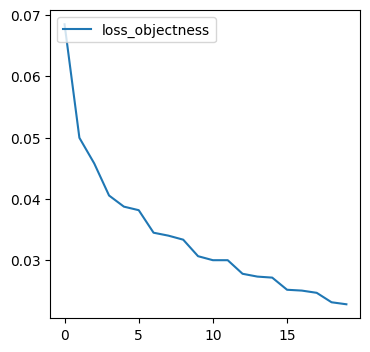

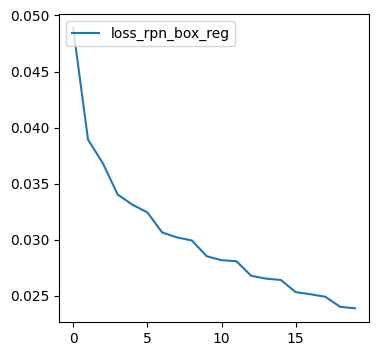

In [9]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


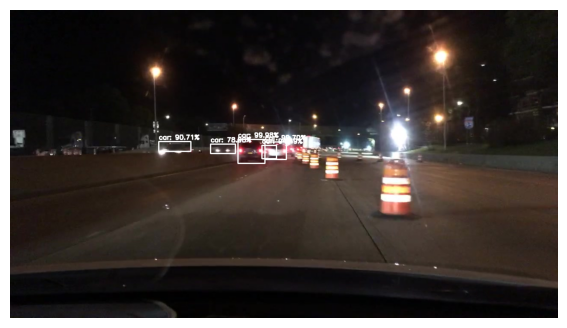

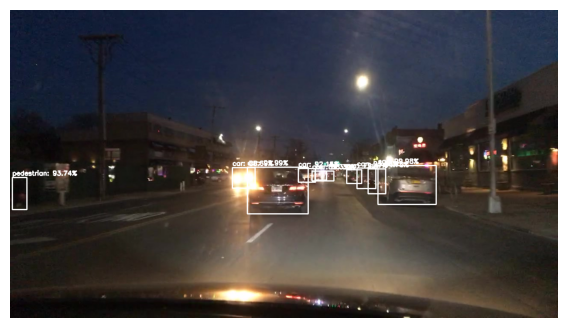

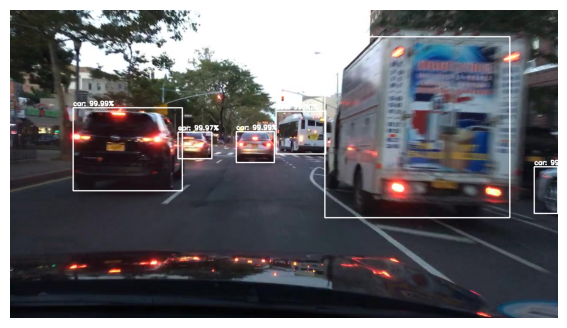

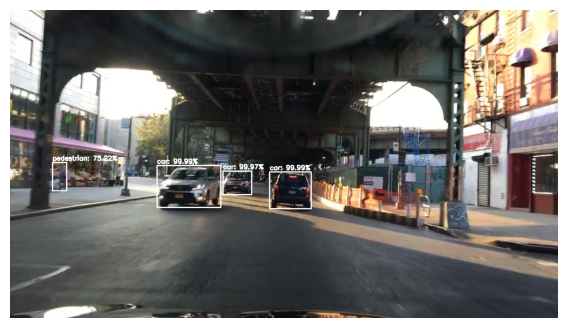

In [10]:
trainer.vis_results(0.75)

In [11]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_vgg(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_vgg, self).__init__()
  
		backbone = torchvision.models.vgg16(weights="DEFAULT").features
		backbone.out_channels = 512
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [12]:


DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_vgg(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/vgg16', lr_scheduler)
trainer.train()

Iterations: 100%|██████████| 3799/3799 [45:33<00:00,  1.39it/s]

Epoch - 1 : loss_classifier = 0.19270560436419482, loss_box_reg = 0.1737857200229841, loss_objectness = 0.1343356964167842, loss_rpn_box_reg = 0.06512774346299738, 


Train Accuracy: mAP=0.09555898606777191
Val Accuracy: mAP=0.0574646033346653


Iterations: 100%|██████████| 3799/3799 [45:31<00:00,  1.39it/s]


Epoch - 2 : loss_classifier = 0.14776494268795695, loss_box_reg = 0.16385154203894453, loss_objectness = 0.08540820347100582, loss_rpn_box_reg = 0.04662114280617003, 


Iterations: 100%|██████████| 3799/3799 [45:22<00:00,  1.40it/s]


Epoch - 3 : loss_classifier = 0.13724647501689977, loss_box_reg = 0.15655652019919675, loss_objectness = 0.07804600512753523, loss_rpn_box_reg = 0.04355852705972952, 


Iterations: 100%|██████████| 3799/3799 [45:14<00:00,  1.40it/s]

Epoch - 4 : loss_classifier = 0.12667763279469021, loss_box_reg = 0.15014559242341918, loss_objectness = 0.06977148247315448, loss_rpn_box_reg = 0.04026724497740341, 


Train Accuracy: mAP=0.18516868352890015
Val Accuracy: mAP=0.08714520931243896


Iterations: 100%|██████████| 3799/3799 [45:11<00:00,  1.40it/s]


Epoch - 5 : loss_classifier = 0.122796293167644, loss_box_reg = 0.1475046962876168, loss_objectness = 0.06713755852360181, loss_rpn_box_reg = 0.039286342160209965, 


Iterations: 100%|██████████| 3799/3799 [45:07<00:00,  1.40it/s]


Epoch - 6 : loss_classifier = 0.11974373830579933, loss_box_reg = 0.14585037586245136, loss_objectness = 0.06521884278423945, loss_rpn_box_reg = 0.0385723964490877, 


Iterations: 100%|██████████| 3799/3799 [45:03<00:00,  1.41it/s]

Epoch - 7 : loss_classifier = 0.11416270929430622, loss_box_reg = 0.1420757333025097, loss_objectness = 0.06052738635806417, loss_rpn_box_reg = 0.03669822129667802, 


Train Accuracy: mAP=0.22467724978923798
Val Accuracy: mAP=0.10491719096899033


Iterations: 100%|██████████| 3799/3799 [45:05<00:00,  1.40it/s]


Epoch - 8 : loss_classifier = 0.11221626758277338, loss_box_reg = 0.141326560640561, loss_objectness = 0.059180698844634345, loss_rpn_box_reg = 0.03622940233358233, 


Iterations: 100%|██████████| 3799/3799 [45:01<00:00,  1.41it/s]


Epoch - 9 : loss_classifier = 0.11103531584108337, loss_box_reg = 0.14065062920100815, loss_objectness = 0.05851404166285946, loss_rpn_box_reg = 0.03592905085205357, 


Iterations: 100%|██████████| 3799/3799 [45:00<00:00,  1.41it/s]

Epoch - 10 : loss_classifier = 0.10627519760783895, loss_box_reg = 0.1374803820203781, loss_objectness = 0.05473744259668192, loss_rpn_box_reg = 0.03436182330480906, 


Train Accuracy: mAP=0.2596346139907837
Val Accuracy: mAP=0.1105833500623703


Iterations: 100%|██████████| 3799/3799 [45:04<00:00,  1.40it/s]


Epoch - 11 : loss_classifier = 0.10523921148040069, loss_box_reg = 0.13696080616475031, loss_objectness = 0.05388295804043763, loss_rpn_box_reg = 0.0341182297583994, 


Iterations: 100%|██████████| 3799/3799 [45:04<00:00,  1.40it/s]


Epoch - 12 : loss_classifier = 0.10351554093827038, loss_box_reg = 0.13601360284331349, loss_objectness = 0.053280347760861865, loss_rpn_box_reg = 0.03388503123325803, 


Iterations: 100%|██████████| 3799/3799 [45:02<00:00,  1.41it/s]

Epoch - 13 : loss_classifier = 0.10005824466239123, loss_box_reg = 0.13321682375594168, loss_objectness = 0.050452418293912775, loss_rpn_box_reg = 0.0326322800761506, 


Train Accuracy: mAP=0.2724429666996002
Val Accuracy: mAP=0.11513548344373703


Iterations: 100%|██████████| 3799/3799 [45:07<00:00,  1.40it/s]


Epoch - 14 : loss_classifier = 0.09832833983566956, loss_box_reg = 0.13199509800884654, loss_objectness = 0.049843461969565815, loss_rpn_box_reg = 0.03239894726454121, 


Iterations: 100%|██████████| 3799/3799 [45:09<00:00,  1.40it/s]


Epoch - 15 : loss_classifier = 0.09747933754641058, loss_box_reg = 0.1320722753647347, loss_objectness = 0.049221787512965284, loss_rpn_box_reg = 0.032174154793954926, 


Iterations: 100%|██████████| 3799/3799 [1:19:20<00:00,  1.25s/it]

Epoch - 16 : loss_classifier = 0.09406877442200064, loss_box_reg = 0.12943667329888997, loss_objectness = 0.04692756963286291, loss_rpn_box_reg = 0.031127319901654064, 


Train Accuracy: mAP=0.2865436375141144
Val Accuracy: mAP=0.1248076781630516


Iterations: 100%|██████████| 3799/3799 [1:37:49<00:00,  1.55s/it]


Epoch - 17 : loss_classifier = 0.0927612316642946, loss_box_reg = 0.1289653172694435, loss_objectness = 0.04610055983537246, loss_rpn_box_reg = 0.030907591656056336, 


Iterations: 100%|██████████| 3799/3799 [1:12:57<00:00,  1.15s/it]


Epoch - 18 : loss_classifier = 0.09200127528419963, loss_box_reg = 0.12820825572036135, loss_objectness = 0.045713556925764946, loss_rpn_box_reg = 0.030781503305403957, 


Iterations: 100%|██████████| 3799/3799 [1:26:50<00:00,  1.37s/it]

Epoch - 19 : loss_classifier = 0.08860381461226899, loss_box_reg = 0.12558860545838216, loss_objectness = 0.04366288452489372, loss_rpn_box_reg = 0.02979580404015788, 


Train Accuracy: mAP=0.30306732654571533
Val Accuracy: mAP=0.12464800477027893


Iterations: 100%|██████████| 3799/3799 [1:25:27<00:00,  1.35s/it]

Epoch - 20 : loss_classifier = 0.08797787088988078, loss_box_reg = 0.1252738700880051, loss_objectness = 0.043092997859286795, loss_rpn_box_reg = 0.029640752964592523, 


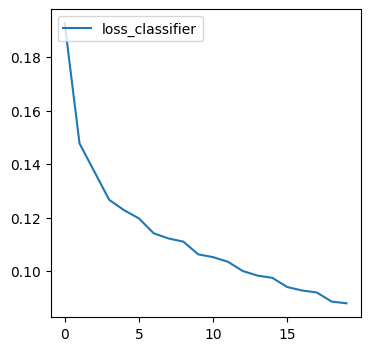

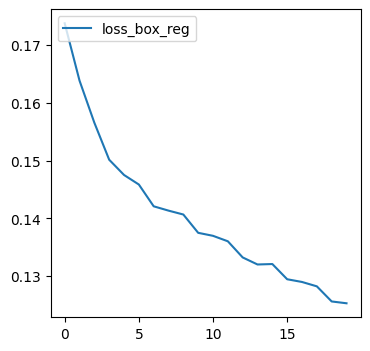

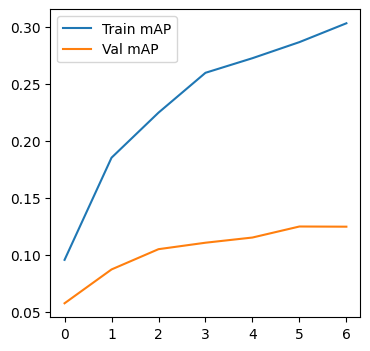

In [13]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


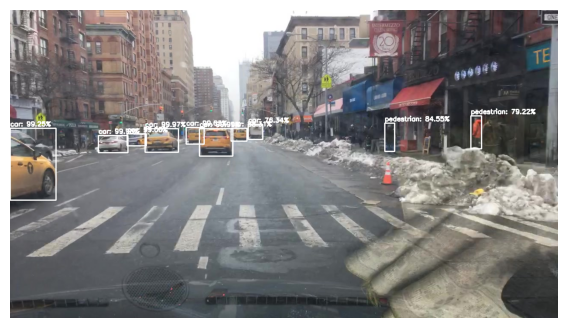

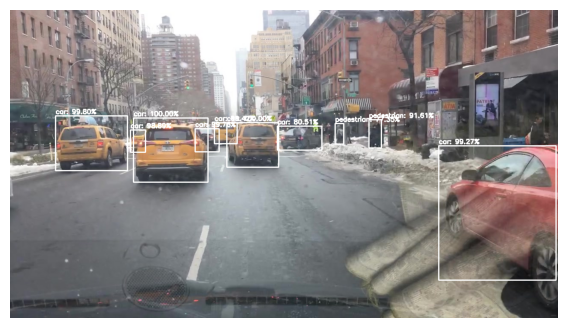

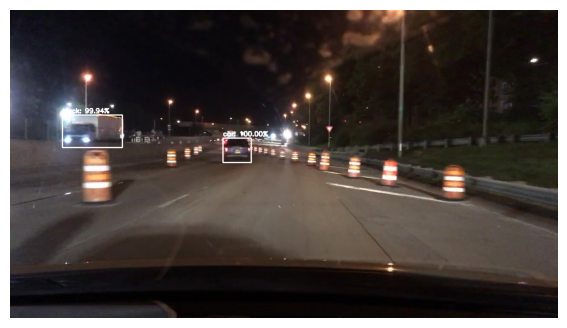

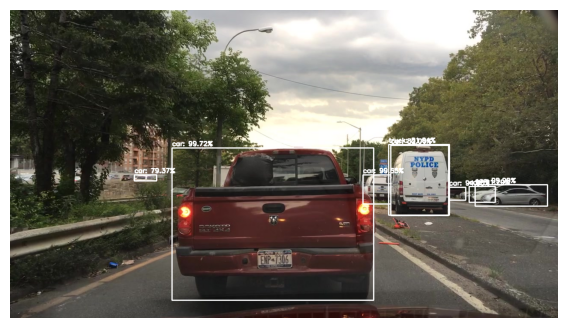

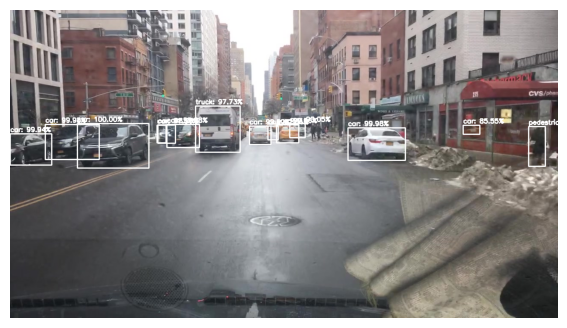

In [14]:
trainer.vis_results(0.75)

In [20]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class model_fasterrcnn_resnet18(nn.Module):
	def __init__(self, num_classes):
		super(model_fasterrcnn_resnet18, self).__init__()
  
		resnet18 = torchvision.models.resnet18(weights="DEFAULT")
		backbone = torch.nn.Sequential(*(list(resnet18.children())[:-2]))
		backbone.out_channels = 512
		anchor_generator = AnchorGenerator(sizes=((64, 128, 512),),
										aspect_ratios=((0.5, 1.0, 2.0),))

		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
												output_size=5,
												sampling_ratio=2)

		self.model = FasterRCNN(backbone,
						num_classes=num_classes,
						rpn_anchor_generator=anchor_generator,
						box_roi_pool=roi_pooler)


		
	def forward(self, x, targets):
		return self.model(x, targets)

	def val(self, x):
	 	return self.model(x)




In [21]:

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model = model_fasterrcnn_resnet18(num_classes=10)
model.to(DEVICE)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), 1e-3, betas=(0.9, 0.999), weight_decay=1e-4)
optimizer.zero_grad()
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

trainer = Trainer(model, num_epochs, optimizer, train_loader, val_loader, DEVICE, 'checkpoints/resnet18', lr_scheduler)
trainer.train()

Iterations:   2%|▏         | 77/3799 [00:26<20:32,  3.02it/s] 

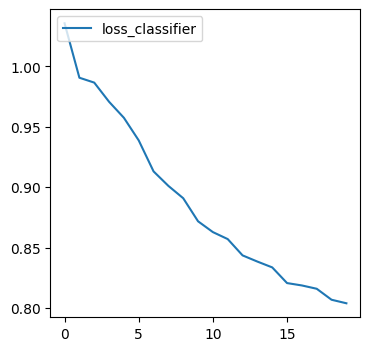

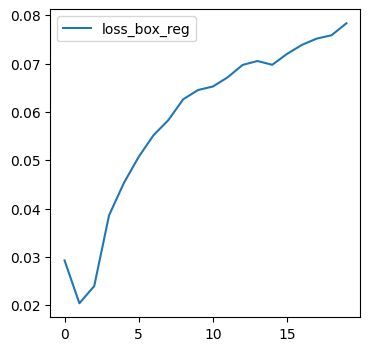

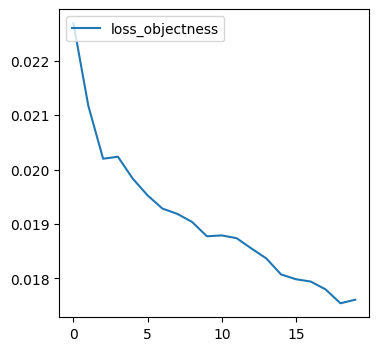

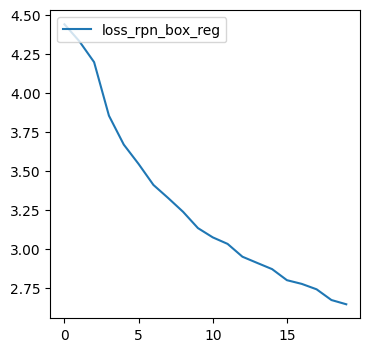

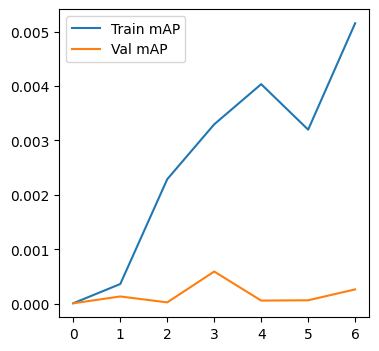

In [ ]:
trainer.plot_history()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


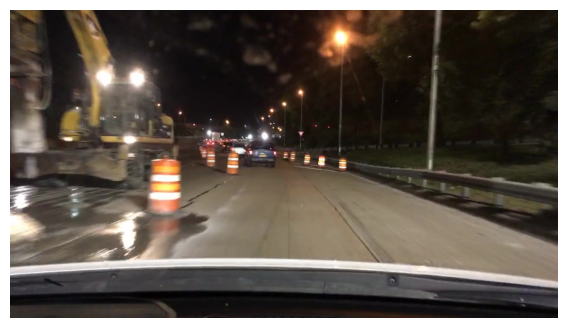

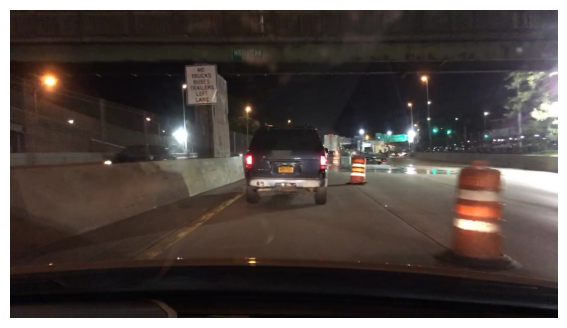

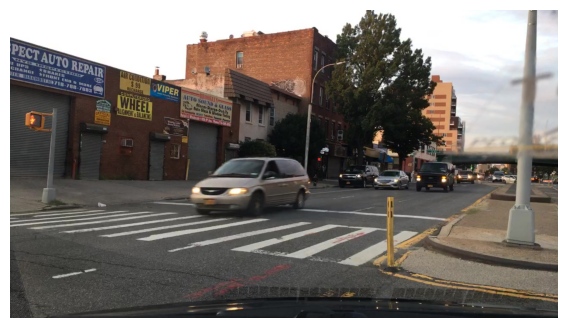

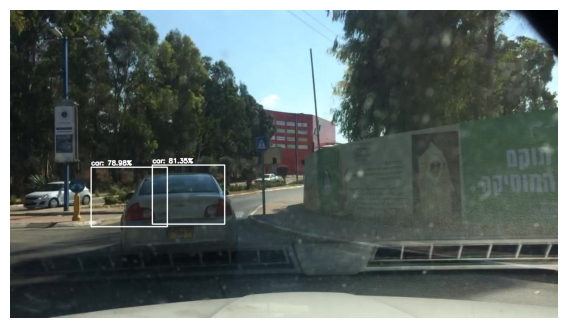

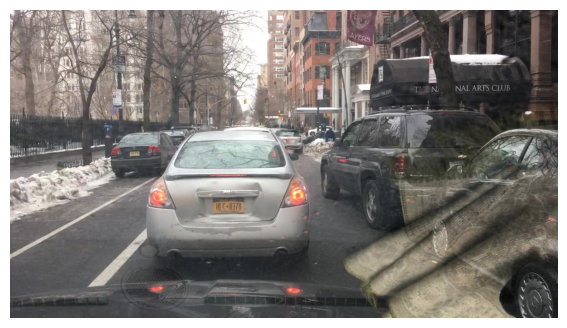

In [ ]:
trainer.vis_results(0.75)

In [ ]:
# from torchvision.models.detection import RetinaNet
# from torchvision.models.detection.rpn import AnchorGenerator

# class model_retinanet_resnet18(nn.Module):
# 	def __init__(self, num_classes):
# 		super(model_retinanet_resnet18, self).__init__()
  
# 		resnet18 = torchvision.models.resnet18(weights="DEFAULT")
# 		backbone = torch.nn.Sequential(*(list(m.children())[:-1]))
# 		backbone.out_channels = 512
# 		anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
# 										aspect_ratios=((0.5, 1.0, 2.0),))

# 		roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
# 												output_size=7,
# 												sampling_ratio=2)

# 		self.model = RetinaNet(backbone,
# 						num_classes=num_classes,
# 						rpn_anchor_generator=anchor_generator,
# 						box_roi_pool=roi_pooler)


		
# 	def forward(self, x, targets):
# 		return self.model(x, targets)

# 	def val(self, x):
# 	 	return self.model(x)


